Modelos Autorregresivos:

LIBRERÍAS:

In [2]:
! pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 13.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.
tensorflow 2.17.0 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 1.22.4 which is incompatible.


In [3]:
! pip install skforecast

In [4]:
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión pdarima: {pmdarima.__version__}")
print(f"{color}Versión statsmodels: {statsmodels.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Versión skforecast: 0.13.0
Versión pdarima: 2.0.4
Versión statsmodels: 0.13.2
Versión pandas: 2.2.3
Versión numpy: 1.22.4


DATOS:

In [5]:
datos = fetch_dataset(name='fuel_consumption', raw=True)
datos = datos[['Fecha', 'Gasolinas']]
datos = datos.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
datos['date'] = pd.to_datetime(datos['date'], format='%Y-%m-%d')
datos = datos.set_index('date')
datos = datos.loc[:'1990-01-01 00:00:00']
datos = datos['litters']
display(datos.head(4))

fuel_consumption
----------------
Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.
Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and
Corporación de Derecho Público tutelada por el Ministerio para la Transición
Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas
Shape of the dataset: (644, 6)


date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
Name: litters, dtype: float64

TRAIN-SET

In [6]:
fin_train = '1980-01-01 23:59:59'
datos_train = datos.loc[:fin_train]
datos_test  = datos.loc[fin_train:]

MODELO SARIMAX

STATMODELS

In [7]:
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

/home/khaosdev/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            litters   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1356.051
Date:                            Mon, 14 Oct 2024   AIC                           2722.103
Time:                                    08:51:03   BIC                           2736.040
Sample:                                01-01-1969   HQIC                          2727.763
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4972      0.134     -3.707      0.000      -0.760      -0.234
ma.L1         -0.0096      0.146     -0.066      0.947      -0.295       0.276
ar.S.L12       0.0465      0.162      0.288      0.774      -0.270       0.364
ma.S.L12      -0.3740      0.203     -1.847      0.065      -0.771       0.023
sigma2      3.291e+08   1.06e-09    3.1e+17      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                18.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.57e+32. Standard errors may be unstable.
"""

Predicción:

In [8]:
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

1980-02-01    407504.056940
1980-03-01    473997.245783
1980-04-01    489983.091512
1980-05-01    485517.462848
Freq: MS, Name: predicciones_statsmodels, dtype: float64

PDMARIMA

In [9]:
modelo = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()

/home/khaosdev/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1355.749
Date:                            Mon, 14 Oct 2024   AIC                           2723.498
Time:                                    08:51:04   BIC                           2740.223
Sample:                                01-01-1969   HQIC                          2730.290
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -474.5820   1101.722     -0.431      0.667   -2633.918    1684.754
ar.L1         -0.4896      0.138     -3.554      0.000      -0.760      -0.220
ma.L1         -0.0211      0.151     -0.139      0.889      -0.317       0.275
ar.S.L12       0.0545      0.164      0.331      0.740      -0.268       0.377
ma.S.L12      -0.3841      0.204     -1.884      0.060      -0.784       0.015
sigma2      3.289e+08      0.002   1.84e+11      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.90   Jarque-Bera (JB):                18.55
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.43
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.73e+27. Standard errors may be unstable.
"""

In [10]:
predicciones_pdmarima = modelo.predict(len(datos_test))
predicciones_pdmarima.name = 'predicciones_pdmarima'
display(predicciones_pdmarima.head(4))

1980-02-01    406998.311416
1980-03-01    472944.444457
1980-04-01    488389.125343
1980-05-01    483432.075679
Freq: MS, Name: predicciones_pdmarima, dtype: float64

MODELOS ARIMA (statsmodel)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [12]:
air_passengers = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'])
air_passengers.set_index('date', inplace=True)

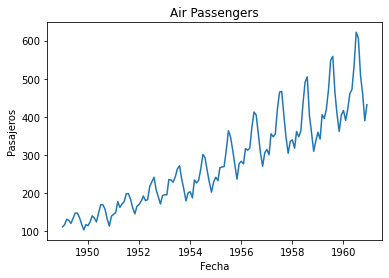

In [13]:
plt.plot(air_passengers)
plt.title('Air Passengers')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.show()

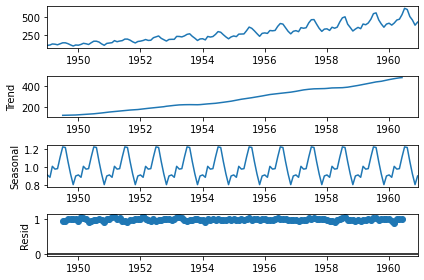

In [14]:
decomposition = sm.tsa.seasonal_decompose(air_passengers, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [15]:
arima_model = sm.tsa.SARIMAX(air_passengers, order=(2,1,2), seasonal_order=(1,1,1,12))
arima_model_fit = arima_model.fit()

/home/khaosdev/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52296D+00    |proj g|=  8.43431D-02

At iterate    5    f=  3.50838D+00    |proj g|=  1.86363D-02

At iterate   10    f=  3.50252D+00    |proj g|=  2.67932D-02

At iterate   15    f=  3.49491D+00    |proj g|=  5.74138D-03

At iterate   20    f=  3.49358D+00    |proj g|=  8.93413D-03

At iterate   25    f=  3.49323D+00    |proj g|=  1.83503D-04

At iterate   30    f=  3.49322D+00    |proj g|=  6.19470D-04

At iterate   35    f=  3.49322D+00    |proj g|=  5.80342D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [16]:
print(arima_model_fit.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -503.024
Date:                              Mon, 14 Oct 2024   AIC                           1020.048
Time:                                      08:51:06   BIC                           1040.174
Sample:                                  01-01-1949   HQIC                          1028.226
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4441      0.388      1.145      0.252      -0.316       1.204
ar.L2          0.32

Ejemplo ARIMA kaggle

In [17]:
import numpy as np
import pandas as pd

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

warnings.filterwarnings("ignore")

In [18]:
# generamos una lista de 110 años para nuestre serie temporal 
años = np.arange(1821, 1931)

# la cantidad de pieles de linces captadas cada año

Pieles = [
269, 321, 585, 871, 1475, 2821, 3928, 5943, 4950, 2577,
523, 98, 184, 279, 409, 2285, 2685, 3409, 1824, 409,
151, 45, 68, 213, 546, 1033, 2129, 2536, 957, 361,
377, 225, 360, 731, 1638, 2725, 2871, 2119, 684, 299,
236, 245, 552, 1623, 3311, 6721, 4254, 687, 255, 473,
358, 784, 1594, 1676, 2251, 1426, 756, 299, 201, 229,
469, 736, 2042, 2811, 4431, 2511, 389, 73, 39, 49,
59, 188, 377, 1292, 4031, 3495, 587, 105, 387, 758,
1307, 3465, 6991, 6313, 3794, 1836, 345, 382, 808, 1388,
2713, 3800, 3091, 2985, 790, 674, 81, 80, 108, 229,
1132, 2432, 3574, 2935, 1537, 529, 485, 662, 1000, 1590
]

In [19]:
# generamos el dataframe completo de nuestro análisis
df = pd.DataFrame([años, Pieles]).T
df.columns = ["Año", "Pieles"]
df["Pieles_log"] = df["Pieles"].apply(np.log)
df["Pieles_log_diff"] = df["Pieles_log"].diff() #Resta el valor del año anterior en este caso (siempre la fecha anterior a la que indiques)
df["Año"] = pd.to_datetime(df["Año"], format = "%Y")
df.set_index("Año", inplace = True)
df.dropna(inplace = True, axis = "rows")
df.head()

,Pieles,Pieles_log,Pieles_log_diff
Año,,,
1822-01-01,321,5.771441,0.176730
1823-01-01,585,6.371612,0.600171
1824-01-01,871,6.769642,0.398030
1825-01-01,1475,7.296413,0.526771
1826-01-01,2821,7.944847,0.648433


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109 entries, 1822-01-01 to 1930-01-01
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pieles           109 non-null    int64  
 1   Pieles_log       109 non-null    float64
 2   Pieles_log_diff  109 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.4 KB


In [21]:
# separar x y la y para el gráfico
x = df.index

y = df["Pieles"]
y_media = [np.mean(y) for _ in y]

y_log = df["Pieles_log"]
y_log_media = [np.mean(y_log) for _ in y_log]

y_log_diff = df["Pieles_log_diff"]
y_log_diff_mean = [np.mean(y_log_diff) for _ in y_log_diff]


In [22]:
for serie, nombre_serie in zip([y, y_log, y_log_diff], ["Serie Original", "Serie Log.", "Serie. Log. Diff"]):
    
    print("------------------------------------------------------------------")
    
    print("Estamos trabajando con la serie {}\n".format(nombre_serie))
    resultado_analisis = adfuller(serie)
    
    valor_estadistico_adf = resultado_analisis[0]
    p_valor = resultado_analisis[1]
    
    print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
    print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))

------------------------------------------------------------------
Estamos trabajando con la serie Serie Original

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -3.0793473736518084

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.028119810051869025

------------------------------------------------------------------
Estamos trabajando con la serie Serie Log.

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -3.6493560033056385

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.0048846046639502635

------------------------------------------------------------------
Estamos trabajando con la serie Serie. Log. Diff

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -3.6799781005511476

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.004403758412051588



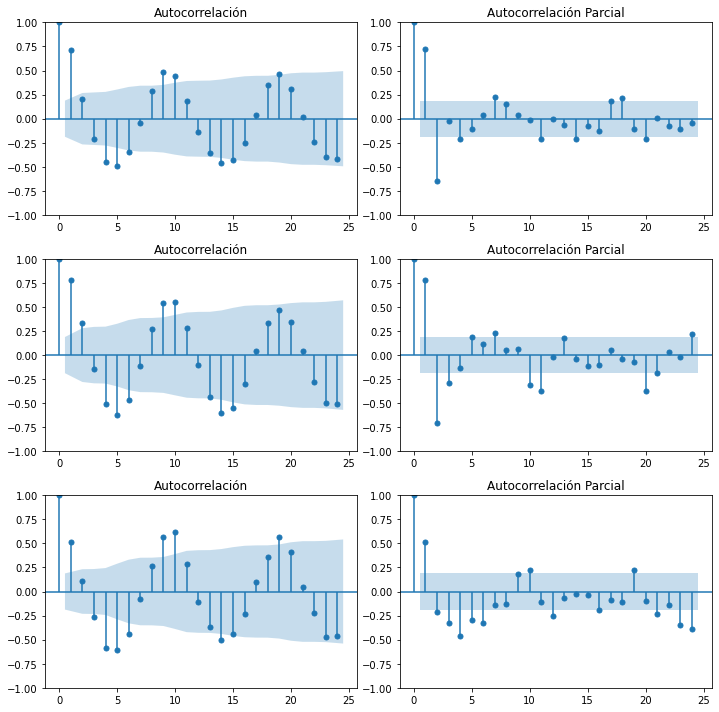

In [23]:
LAGS = 24

fig = plt.figure(figsize = (10, 10))

((ax1, ax2), (ax3, ax4), (ax5, ax6)) = fig.subplots(3, 2)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module
plot_acf(y, ax = ax1, lags = LAGS, title = "Autocorrelación")
plot_pacf(y, ax = ax2, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(y_log, ax = ax3, lags = LAGS, title = "Autocorrelación")
plot_pacf(y_log, ax = ax4, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(y_log_diff, ax = ax5, lags = LAGS, title = "Autocorrelación")
plot_pacf(y_log_diff, ax = ax6, lags = LAGS, title = "Autocorrelación Parcial")

fig.tight_layout()


In [24]:
serie_a_predecir = y_log
y_index = serie_a_predecir.index

date_train = int(len(y_index)*0.9)

y_train = serie_a_predecir[y_index[:date_train]]
y_test = serie_a_predecir[y_index[date_train:len(y_index)]]

In [25]:
y_train.tail()

Año
1915-01-01    6.672033
1916-01-01    6.513230
1917-01-01    4.394449
1918-01-01    4.382027
1919-01-01    4.682131
Name: Pieles_log, dtype: float64

In [26]:
y_test.head()

Año
1920-01-01    5.433722
1921-01-01    7.031741
1922-01-01    7.796469
1923-01-01    8.181441
1924-01-01    7.984463
Name: Pieles_log, dtype: float64

In [27]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Vamos a utilizar el modelo SARIMAX, porque en su implementaciòn en Python existen herramientas adicionales
# que nos facilitan el análisis y que no están disponibles en la implementación de ARIMA.

# Ahora bien, SARIMAX es un modelo ARIMA pero con un componente estacional (la leta S de Seasonal) y también
# un componente exógeno (X de eXogenous regressors)
# Por tanto un modelo SARIMAX de (1, 1, 1) x (0, 0, 0, 0)
# Es un modelo ARIMA (1, 1, 1)

# En caso de querer probar un modelo SARIMAX completo, ejecutar la siguiente línea de itertools.
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Los dejamos a cero para sólo analizar un modelo ARIMA.
seasonal_pdq = [(0, 0, 0, 0)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


In [28]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        # alguna combinación de parámetros en SARIMAX, no son válidos
        # y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("La búsqueda de parámetros no ha llevado {} minutos!".format((et - st)/60))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29895D+00    |proj g|=  4.11813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.080D-08   3.299D+00
  F =   3.2989435794374078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:648.5929415697319
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24964D+00    |proj g|=  3.11870D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   3.118D-04   1.250D+00
  F =   1.2496429929890389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:248.93002662585164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variable

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominat

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19780D+00    |proj g|=  4.32506D-01

At iterate    5    f=  1.09840D+00    |proj g|=  6.90899D-02

At iterate   10    f=  1.09160D+00    |proj g|=  2.25745D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   7.717D-06   1.092D+00
  F =   1.0915960099410067     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:221.9528179484373
RUNNING THE L-BF

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.09724D+00    |proj g|=  4.30719D-03

At iterate   15    f=  1.09669D+00    |proj g|=  1.45503D-02

At iterate   20    f=  9.99722D-01    |proj g|=  4.17922D-01

At iterate   25    f=  9.44205D-01    |proj g|=  3.19456D-02

At iterate   30    f=  9.44165D-01    |proj g|=  1.40508D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     66      1     0     0   1.405D-04   9.442D-01
  F =  0.94416525657222117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2)x(0, 0, 0, 0)12 - AIC:195.05639028815534
La búsqueda de parámetros no ha llevado 0.0154401739438374

In [29]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))


El mejor modelo es (2, 1, 2), 
Con un AIC de 179.02258657020866


In [30]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order = best_params,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02147D+00    |proj g|=  5.75822D-01

At iterate    5    f=  8.84630D-01    |proj g|=  8.02617D-02

At iterate   10    f=  8.66475D-01    |proj g|=  1.42145D-01

At iterate   15    f=  8.62362D-01    |proj g|=  5.14781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   2.070D-06   8.624D-01
  F =  0.86236013556228908     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [31]:
results = mod.fit()

print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02147D+00    |proj g|=  5.75822D-01

At iterate    5    f=  8.84630D-01    |proj g|=  8.02617D-02

At iterate   10    f=  8.66475D-01    |proj g|=  1.42145D-01

At iterate   15    f=  8.62362D-01    |proj g|=  5.14781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   2.070D-06   8.624D-01
  F =  0.86236013556228908     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

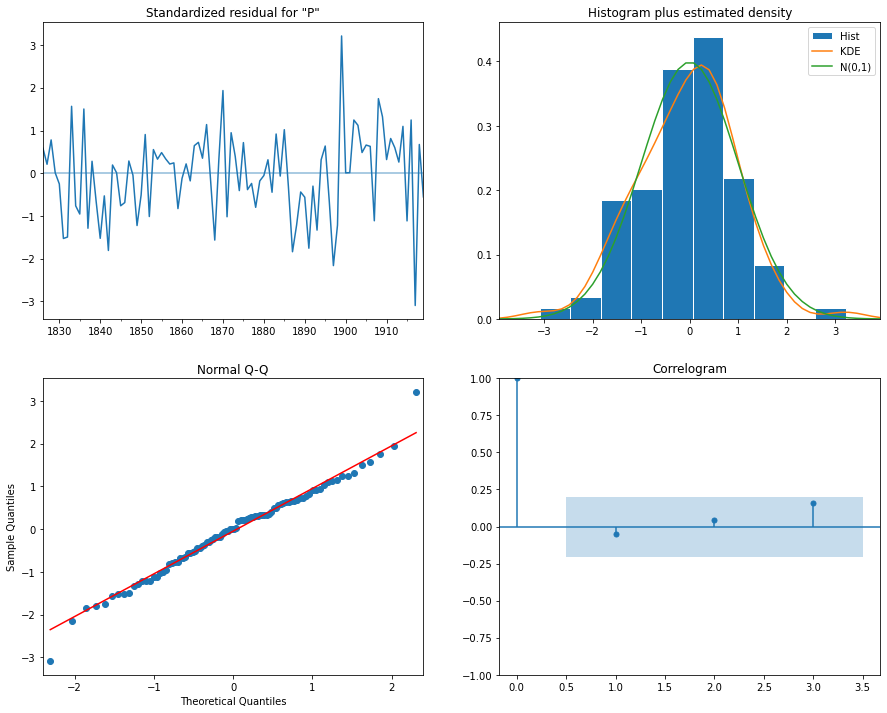

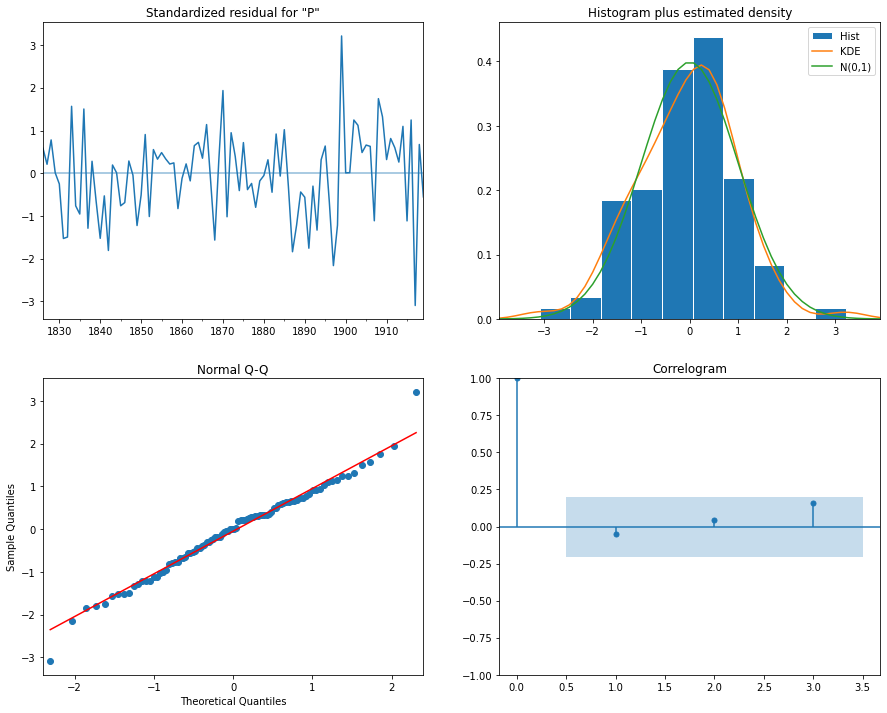

In [32]:
results.plot_diagnostics(figsize = (15, 12), lags = 3)


In [33]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = results.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()

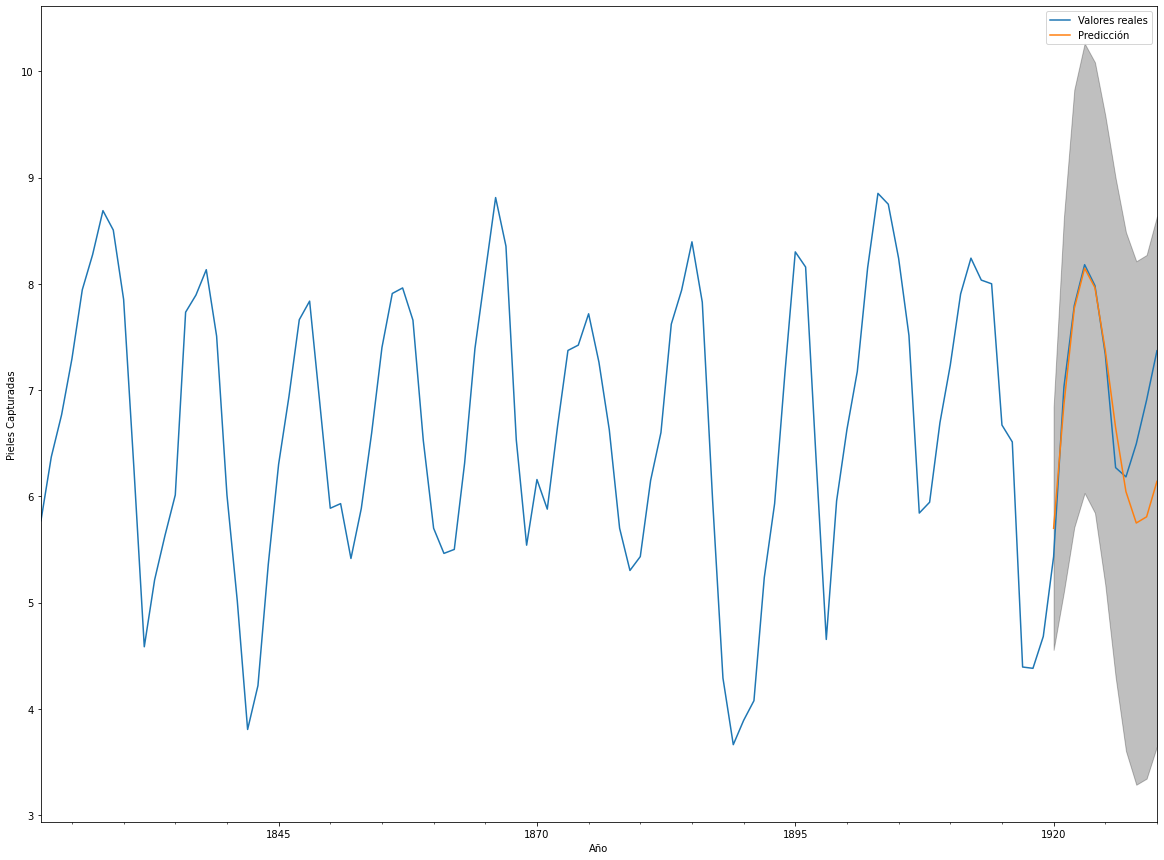

In [34]:
ax = serie_a_predecir.plot(label = 'Valores reales', figsize = (20, 15))

pred_uc.predicted_mean.plot(ax = ax, label = 'Predicción')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Año')
ax.set_ylabel('Pieles Capturadas')

plt.legend()
plt.show()

In [35]:
y_pred = pred_ci.iloc[:, 0]


In [36]:
# El RMSE es de 2.52
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("El modelo ARIMA con los parametros {}, ha dado un rmse en test de {}".format(best_params, round(rmse, 2)))

El modelo ARIMA con los parametros (2, 1, 2), ha dado un rmse en test de 2.53
